Let's load the basic modules and read the tables from disk

In [ ]:
import numpy as np
import astropy.units as u
from astropy.table import Table, QTable
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

We load the two tables we generated in the last session. `data1` contains the Gaia query in a rectangle around our region of interest, excluding negative parallaxes. `cluster1` is our selection on the previous table to select sources with parallaxes between 5.0 and 5.7 mas.

In [2]:
data1 = Table.read('../data/data1.ecsv')
cluster1 = Table.read('../data/cluster1.ecsv')

## ADQL searches

In [ ]:
def send_radial_gaia_query(query_size=1000000, distance=200, **kwargs):
    """
    Sends an archive query for d < 200 pc, with additional filters taken from
    Gaia Data Release 2: Observational Hertzsprung-Russell diagrams (Sect. 2.1)
    Gaia Collaboration, Babusiaux et al. (2018)
    (https://doi.org/10.1051/0004-6361/201832843)

    NOTE: 10000000 is a maximum query size (~76 MB / column)

    Additional keyword arguments are passed to TapPlus.launch_job_async method.
    """
    from astroquery.utils.tap.core import TapPlus

    gaia = TapPlus(url="http://gea.esac.esa.int/tap-server/tap")

    job = gaia.launch_job_async("select top {}".format(query_size)+
                #" lum_val, teff_val,"
                #" ra, dec, parallax,"
" bp_rp, phot_g_mean_mag+5*log10(parallax)-10 as mg"
" from gaiadr2.gaia_source"
" where parallax_over_error > 10"
" and visibility_periods_used > 8"
" and phot_g_mean_flux_over_error > 50"
" and phot_bp_mean_flux_over_error > 20"
" and phot_rp_mean_flux_over_error > 20"
" and phot_bp_rp_excess_factor <"
" 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)"
" and phot_bp_rp_excess_factor >"
" 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)"
" and astrometric_chi2_al/(astrometric_n_good_obs_al-5)<"
"1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))"
" and 1000/parallax <= {}".format(distance), **kwargs)

    return job

In [ ]:
import numpy as np

job = send_radial_gaia_query(dump_to_file=True, output_format="csv",
                                 output_file="gaia-hrd-dr2-200pc.csv",
                                 query_size=10000000)
r = job.get_results()
bp_rp = r['bp_rp'].data
mg = r['mg'].data

In [ ]:
table_metadata = Gaia.load_table('gaiadr2.gaia_source')
table_metadata


In [ ]:
query1 = """SELECT 
TOP 10
source_id, ra, dec, parallax 
FROM gaiadr2.gaia_source
"""

job1 = Gaia.launch_job(query1)
job1


# Advanced plotting with multiple panels

First, we are going to plot two figures together. These will be created as individual axis, so here `ax` is a list, and we can access the diferent axes with `ax[0]`, `ax[1]`, ...

Now we are going to plot two panels to visualize the `parallax` and the `distance` at the same time.

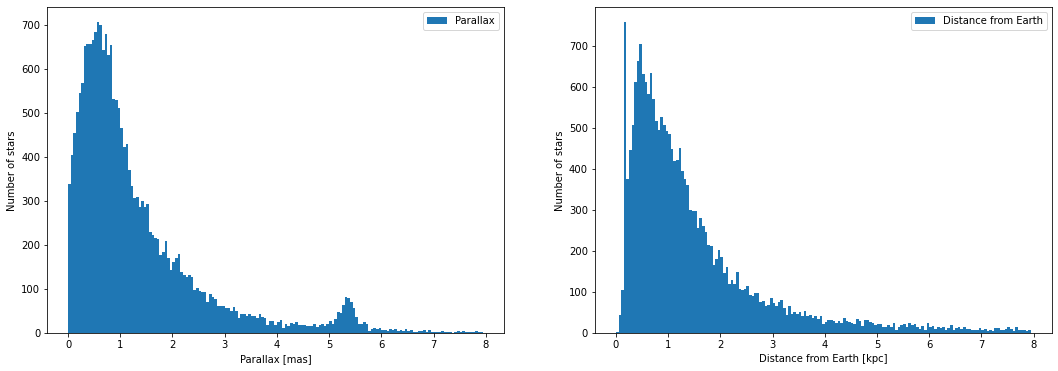

In [28]:
col1 = 'parallax'
col2 = 'distance'

fig, ax = plt.subplots(ncols=2, figsize=(18,6))   # We can select ncols, nrows, or both.

ax[0].hist(data1[col1], bins=np.arange(0, 8, 0.05), label=data1[col1].description)
ax[1].hist(data1[col2], bins=np.arange(0, 8, 0.05), label=data1[col2].description) # Try 0.01 kpc steps

ax[0].legend()
ax[1].legend()

description1 = data1[col1].description
unit1 = data1[col1].unit
description2 = data1[col2].description
unit2 = data1[col2].unit

ax[0].set_xlabel(f"{description1} [{unit1}]")
ax[1].set_xlabel(f"{description2} [{unit2}]")

ax[0].set_ylabel('Number of stars')
ax[1].set_ylabel('Number of stars');

### ✨ Exercise

- Prepare a 2x2 hisotgrams for `ra`, `dec`, `parallax`, `distance`. Use `plt.subplots(ncols=2, nrows=2` and select a figsize in accordance to the number of plots.
- Remember to add labels and a legend for all axes.
- Remember to include `xlabel` (automatically) and `ylabel` (manually) for all axes.

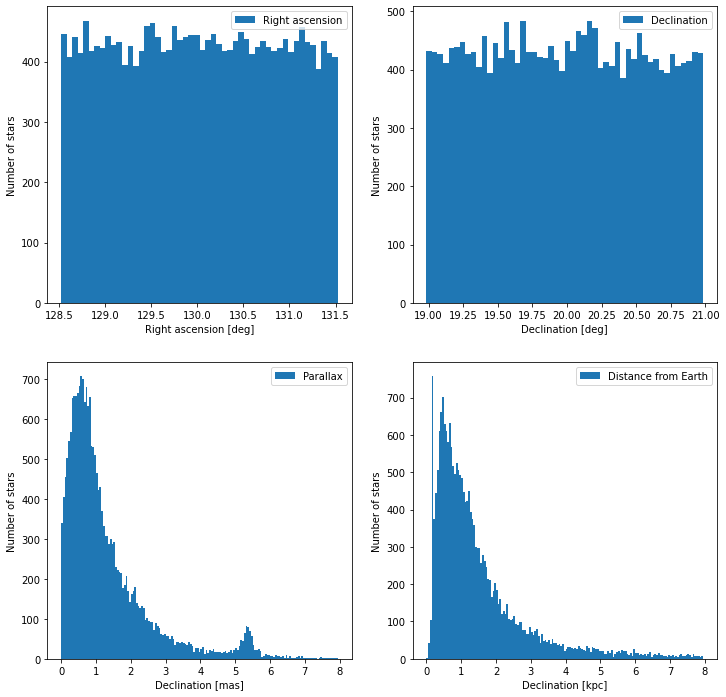

In [34]:
col1 = 'ra'
col2 = 'dec'
col3 = 'parallax'
col4 = 'distance'

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,12))   # We can select ncols, nrows, or both.

ax[0,0].hist(data1[col1], bins=50, label=data1[col1].description)
ax[0,1].hist(data1[col2], bins=50, label=data1[col2].description) # Try 0.01 kpc steps
ax[1,0].hist(data1[col3], bins=np.arange(0, 8, 0.05), label=data1[col3].description)
ax[1,1].hist(data1[col4], bins=np.arange(0, 8, 0.05), label=data1[col4].description) # Try 0.01 kpc steps


ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

description1 = data1[col1].description
unit1 = data1[col1].unit
description2 = data1[col2].description
unit2 = data1[col2].unit
description3 = data1[col2].description
unit3 = data1[col3].unit
description4 = data1[col2].description
unit4 = data1[col4].unit

ax[0,0].set_xlabel(f"{description1} [{unit1}]")
ax[0,1].set_xlabel(f"{description2} [{unit2}]")
ax[1,0].set_xlabel(f"{description3} [{unit3}]")
ax[1,1].set_xlabel(f"{description4} [{unit4}]")

ax[0,0].set_ylabel('Number of stars')
ax[0,1].set_ylabel('Number of stars')
ax[1,0].set_ylabel('Number of stars')
ax[1,1].set_ylabel('Number of stars');

Now let's simplify all the tedious repetitive code.

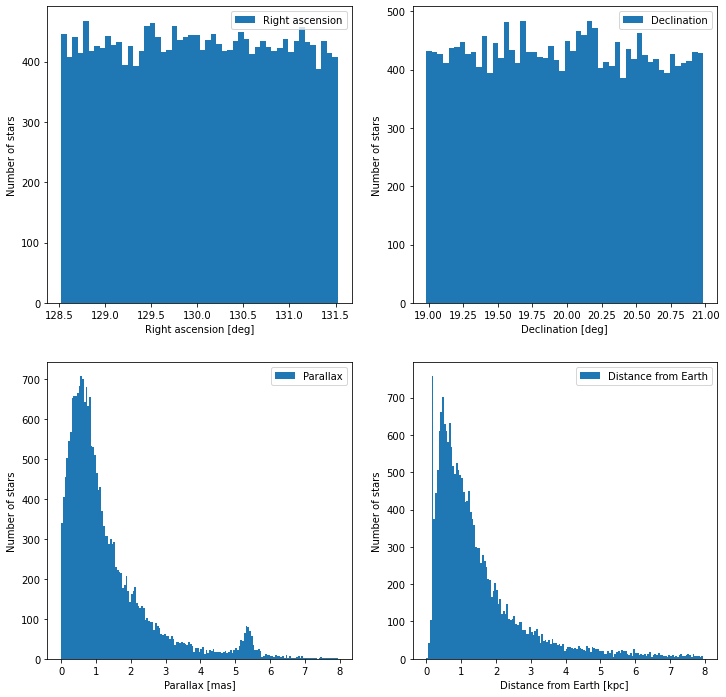

In [37]:
col1 = 'ra'
col2 = 'dec'
col3 = 'parallax'
col4 = 'distance'

cols = [col1, col2, col3, col4]

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,12))   # We can select ncols, nrows, or both.

ax[0,0].hist(data1[col1], bins=50, label=data1[col1].description)
ax[0,1].hist(data1[col2], bins=50, label=data1[col2].description) # Try 0.01 kpc steps
ax[1,0].hist(data1[col3], bins=np.arange(0, 8, 0.05), label=data1[col3].description)
ax[1,1].hist(data1[col4], bins=np.arange(0, 8, 0.05), label=data1[col4].description) # Try 0.01 kpc steps

for col, axi in zip(cols, ax.flatten()):
    axi.legend()
    description = data1[col].description
    unit = data1[col].unit
    axi.set_xlabel(f"{description} [{unit}]")
    axi.set_ylabel('Number of stars')


### 🌪 Exercise
Redo the previous plot show each panel shows both the Total Sample and the Cluster subset.

## Simplify repetitive tasks more

In [5]:
def str_label(tab, col):
    return f"{tab[col].description} [{tab[col].unit}]"

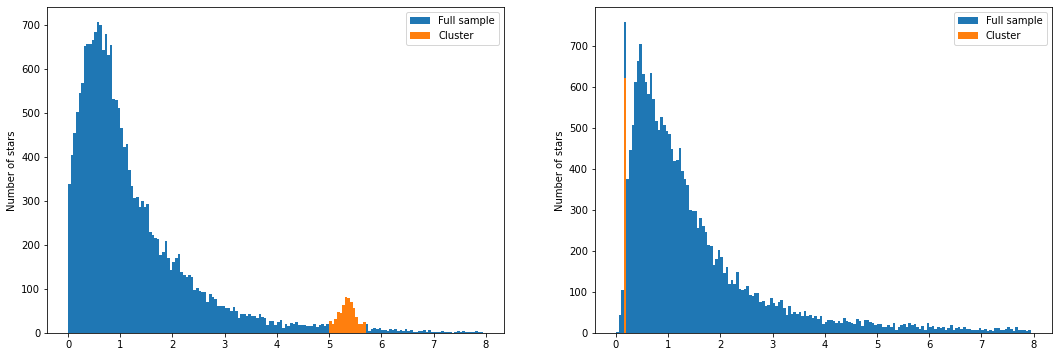

In [41]:
col1 = 'parallax'
col2 = 'distance'

cols = [col1, col2]
fig, ax = plt.subplots(ncols=2, figsize=(18,6))   # We can select ncols, nrows, or both.

for col, axi in zip(cols, ax):
    axi.hist(data1[col], bins=np.arange(0, 8, 0.05), label='Full sample')
    axi.hist(cluster1[col], bins=np.arange(0, 8, 0.05), label='Cluster')
    axi.legend()
    axi.set_label(str_label(data1, col))
    axi.set_ylabel('Number of stars')

Now, let's write a function to simplify one on one plots

In [125]:
def plot_variables(data, col1, col2, ax, **kwargs):
    ax.scatter(data[col1], data[col2], **kwargs)
    ax.set_xlabel(str_label(data, col1))
    ax.set_ylabel(str_label(data, col2))
    ax.legend()
    return ax

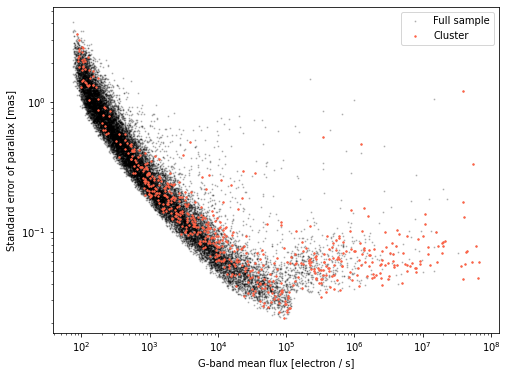

In [126]:
col1 = 'phot_g_mean_flux'
col2 = 'parallax_error'

fig, ax = plt.subplots(figsize=(8,6))   # We can select ncols, nrows, or both.

plot_variables(data1, col1, col2, ax, s=1, c='k', alpha=0.2, label='Full sample')
plot_variables(cluster1, col1, col2, ax, s=2, c='tomato', label='Cluster');

ax.loglog();

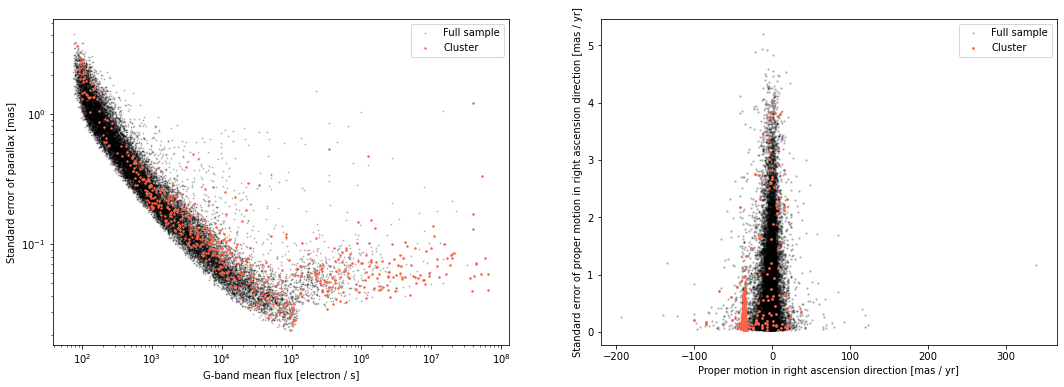

In [127]:
col1 = 'phot_g_mean_flux'
col2 = 'parallax_error'
col3 = 'pmra'
col4 = 'pmra_error'

fig, ax = plt.subplots(ncols=2, figsize=(18,6))   # We can select ncols, nrows, or both.

plot_variables(data1, col1, col2, ax[0], s=1, c='k', alpha=0.2, label='Full sample')
plot_variables(cluster1, col1, col2, ax[0], s=2, c='tomato', label='Cluster')

plot_variables(data1, col3, col4, ax[1], s=2, c='k', alpha=0.2, label='Full sample')
plot_variables(cluster1, col3, col4, ax[1], s=3, c='tomato', label='Cluster')

ax[0].loglog();

## Velocity distribution analysis
We will try to find some clustering pattern in the velocity space. These are the variables:  

Proper motion in right ascension is $\mu_{\alpha}\cos\delta$  
Proper motion in declination is $\mu_{\delta}$  
Spectroscopic radial velocity in the solar barycentric reference frame is $v_{r}$

### ✨ Exercise

- Make a plot of the proper motion in declination vs the proper motion in right ascension for the full sample and for the cluster.
- Use `ax.set_aspect('equal')` so both axes represent the same scales.
- Zoom with `set_xlim` and `set_ylim` until you see the relevant part of the plot.
- Can you approximately guess the mean proper motion of the cluster?

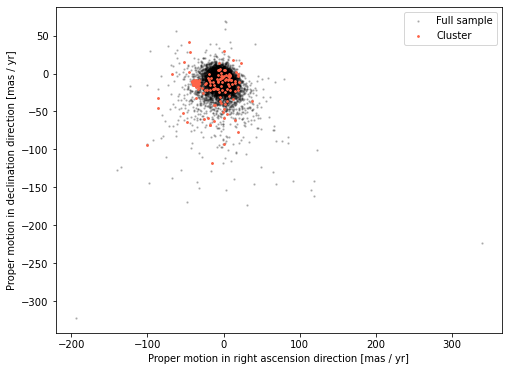

In [132]:
col1 = 'pmra'
col2 = 'pmdec'

fig, ax = plt.subplots(figsize=(8,6))   # We can select ncols, nrows, or both.

plot_variables(data1, col1, col2, ax, s=2, c='k', alpha=0.2, label='Full sample')
plot_variables(cluster1, col1, col2, ax, s=3, c='tomato', label='Cluster');

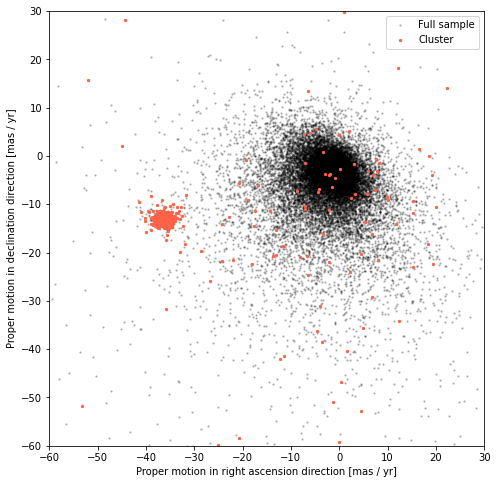

In [136]:
col1 = 'pmra'
col2 = 'pmdec'

fig, ax = plt.subplots(figsize=(8,6))   # We can select ncols, nrows, or both.

plot_variables(data1, col1, col2, ax, s=2, c='k', alpha=0.2, label='Full sample')
plot_variables(cluster1, col1, col2, ax, s=5, c='tomato', label='Cluster');

ax.set_aspect('equal')
ax.set_xlim(-60, 30)
ax.set_ylim(-60, 30);

Great, this is much clearer! The cluster is a moving group, where most of the stars have a very similar 2D velocity, even if they are positionally scattered in a wide region of the sky of several degrees. This indicates that the cluster of stars, probably very young, was formed at a similar time from a single gas cloud, so on average they have the same space velocity as the original cloud.

Note that the selection based on distance alone give a large contamination of stars that don't look like stars from the cluster. A better selection algorithm is needed to avoid those outliers.

### 🌪 Exercise
Draw some extra thing in the previous plot, for example a cross on the average proper motion of the cluster, and the median.

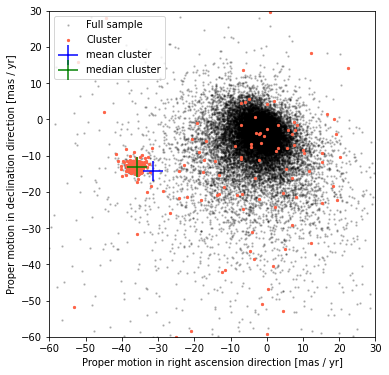

In [291]:
col1 = 'pmra'
col2 = 'pmdec'

fig, ax = plt.subplots(figsize=(8,6))   # We can select ncols, nrows, or both.

plot_variables(data1, col1, col2, ax, s=2, c='k', alpha=0.2, label='Full sample')
plot_variables(cluster1, col1, col2, ax, s=5, c='tomato', label='Cluster');

ax.scatter(cluster1['pmra'].mean(), cluster1['pmdec'].mean(),
           marker='+', c='b', s = 400, label='mean cluster')
ax.scatter(np.median(cluster1['pmra']), np.median(cluster1['pmdec']),
           marker='+', c='g', s = 400, label='median cluster')

ax.set_aspect('equal')

ax.set_xlim(-60, 30)
ax.set_ylim(-60, 30)

ax.legend();

We can also plot the radial velocity, although the information is much more limited because only stars that are very close, or very bright will have measurements. Therefore, radial velocity is biased because most of the stars in our cluster will have good measurements because they are nearby. We can see that the cluster is very well defined in the 3D velocity as well.

In [141]:
# Counting the number of stars with valid measurements
data1[['pmra', 'pmdec', 'radial_velocity']].info()

<Table length=21475>
      name       dtype    unit                  description                    class     n_bad
--------------- ------- -------- ------------------------------------------ ------------ -----
           pmra float64 mas / yr Proper motion in right ascension direction       Column     0
          pmdec float64 mas / yr     Proper motion in declination direction       Column     0
radial_velocity float64   km / s                            Radial velocity MaskedColumn 20894


### ✨ Exercise

Make a three panel plot to represent. 
- `pmdec` vs `pmra`
- `radial_velocity` vs `pmra`
- `radial_velocity` vs `pmdec`
Plot only the full sample and, if you want, also the cluster subset.

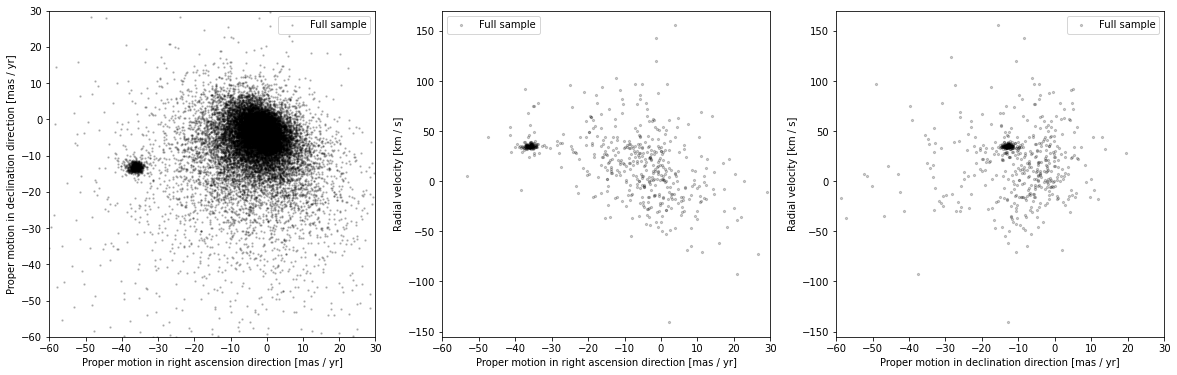

In [152]:
col1 = 'pmra'
col2 = 'pmdec'
col3 = 'radial_velocity'

fig, ax = plt.subplots(ncols=3, figsize=(20,6))   # We can select ncols, nrows, or both.

plot_variables(data1, col1, col2, ax[0], s=2, c='k', alpha=0.2, label='Full sample')
plot_variables(data1, col1, col3, ax[1], s=5, c='k', alpha=0.2, label='Full sample')
plot_variables(data1, col2, col3, ax[2], s=5, c='k', alpha=0.2, label='Full sample')

ax[0].set_aspect('equal')
ax[0].set_xlim(-60, 30)
ax[0].set_ylim(-60, 30)
ax[1].set_xlim(-60, 30)
ax[2].set_xlim(-60, 30);

Now we will see how the values distribution looks like

### ✨ Exercise

- Make a 3 panel plot showing the histograms for `pmra`, `pmdec` and `radial_velocity`
- Include both the full sample and the cluster subset.
- Make sure each panel has an adequate `bins` distribution, and that it is the same for the full and cluster samples. Tip: you can create a list with 3 items, each one being a `np.linespace` object.
- Tip2: for `radial_velocity` select the `bins` that do not select value 0, for example use `np.linspace(1, 60, 50)`.

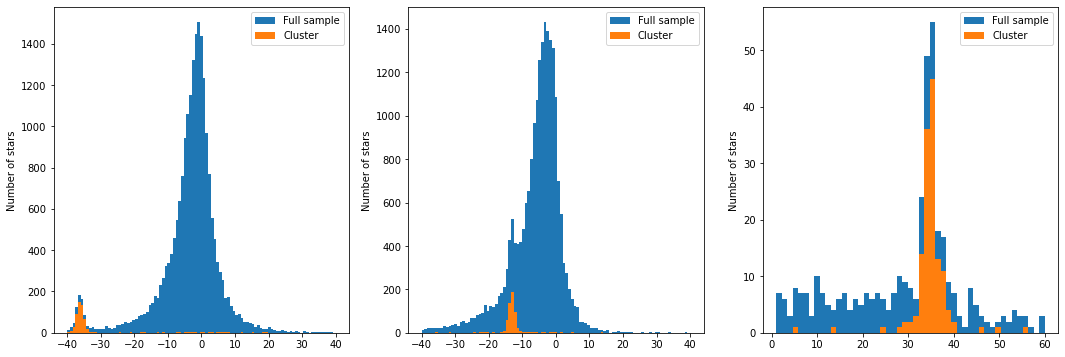

In [158]:
col1 = 'pmra'
col2 = 'pmdec'
col3 = 'radial_velocity'

cols = [col1, col2, col3]
fig, ax = plt.subplots(ncols=3, figsize=(18,6))   # We can select ncols, nrows, or both.

bins = [
    np.linspace(-40, 40, 100),
    np.linspace(-40, 40, 100),
    np.linspace(1, 60, 50)
]

for col, axi, binsi in zip(cols, ax, bins):
    axi.hist(data1[col], bins=binsi, label='Full sample')
    axi.hist(cluster1[col], bins=binsi, label='Cluster')
    axi.legend()
    axi.set_label(str_label(data1, col))
    axi.set_ylabel('Number of stars')

## Velocity field
Finally, we can plot the velocity field of the stars. Given the large number of stars it is difficult to have a clear picture of the velocity directions and magnitudes of the whole sample. But at least we can see that the great majority of the sample stars have random velocities on all directions while the cluster stars have a predominant 2D direction and sense.

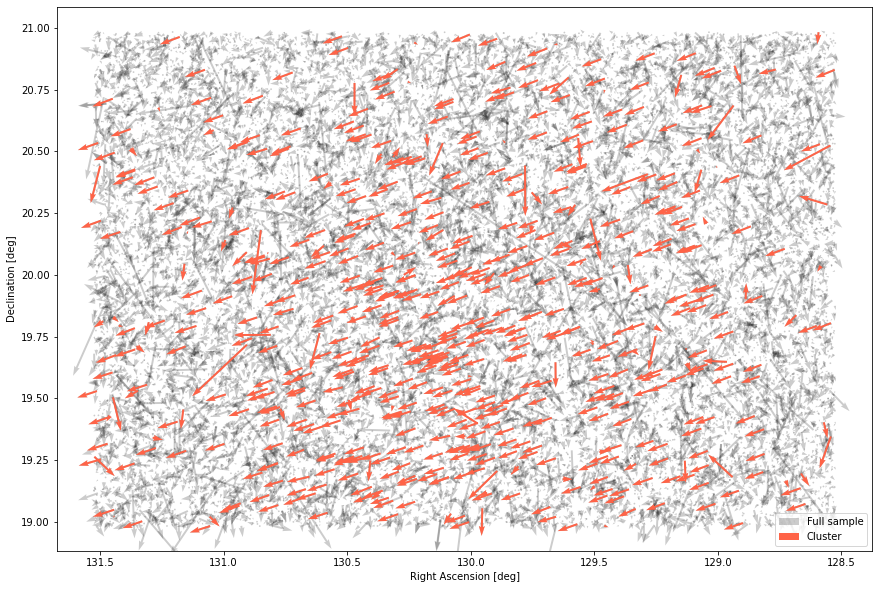

In [160]:
fig, ax = plt.subplots(ncols=1, figsize=(15,10))

ax.quiver(data1['ra'], data1['dec'], data1['pmra'], data1['pmdec'],
          alpha=0.2, cmap=plt.get_cmap('Greys_r'), scale=1500, label='Full sample');

ax.quiver(cluster1['ra'], cluster1['dec'], cluster1['pmra'], cluster1['pmdec'],
           alpha=1, color='tomato', scale=1500, label='Cluster');
ax.set_aspect('equal')

# Here we invert the direction of the right ascension axis
ax.invert_xaxis()

ax.set_xlabel('Right Ascension [deg]')
ax.set_ylabel('Declination [deg]');

ax.legend();

# Analysis of the cluster kinematics in the Galaxy

In [264]:
data1_coord = SkyCoord(ra=data1['ra'],
                       dec=data1['dec'],
                       pm_ra_cosdec=data1['pmra'],
                       pm_dec=data1['pmdec'],
                       frame='icrs')

data1_galactic = data1_coord.galactic

cluster1_coord = SkyCoord(ra=cluster1['ra'],
                         dec=cluster1['dec'],
                         pm_ra_cosdec=cluster1['pmra'],
                         pm_dec=cluster1['pmdec'],
                         frame='icrs')
cluster1_galactic = cluster1_coord.galactic


In [172]:
cluster1_galactic[0:5]

<SkyCoord (Galactic): (l, b) in deg
    [(205.51167197, 32.5370944 ), (205.56054498, 32.54301842),
     (205.54094569, 32.56530788), (205.47365828, 32.51819561),
     (205.47841585, 32.49039637)]
 (pm_l_cosb, pm_b) in mas / yr
    [(-0.98876064, -37.55255505), ( 0.63342759, -37.83331984),
     (-0.4762535 , -37.61259919), ( 3.1594367 , -39.01279467),
     ( 0.30598392, -38.58784794)]>

In [173]:
len(cluster1_galactic)

621

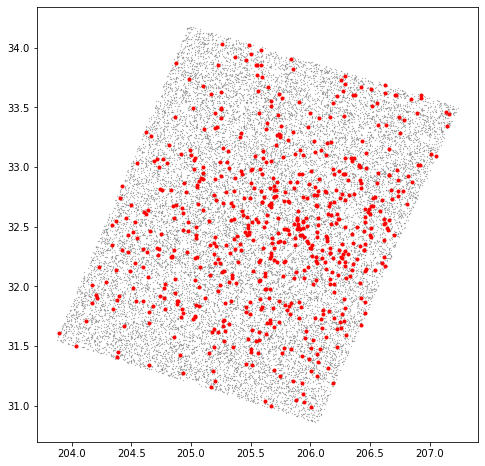

In [180]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(data1_galactic.l, data1_galactic.b, color='grey', marker='.', ms=0.5, ls='')
ax.plot(cluster1_galactic.l, cluster1_galactic.b, 'r.')

ax.set_aspect('equal')

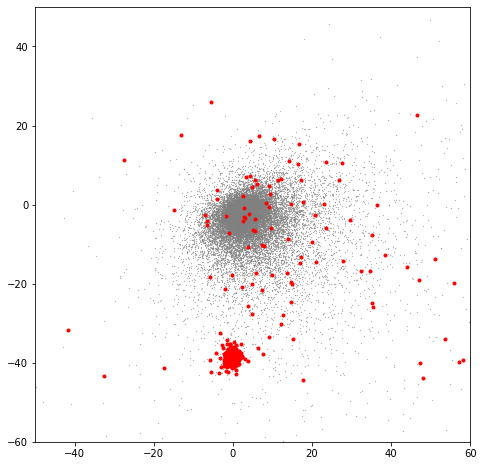

In [183]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(data1_galactic.pm_l_cosb, data1_galactic.pm_b, color='grey', marker='.', ms=0.5, ls='')
ax.plot(cluster1_galactic.pm_l_cosb, cluster1_galactic.pm_b, 'r.')

ax.set_xlim(-50, 60)
ax.set_ylim(-60, 50)
ax.set_aspect('equal')

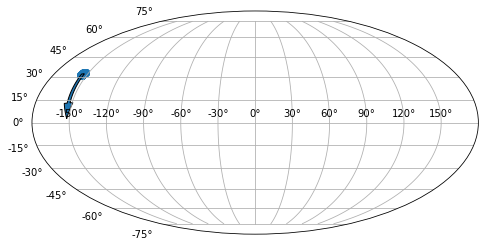

In [205]:
from astropy.coordinates import Angle

l_cluster = Angle(cluster1_galactic.l)
b_cluster = Angle(cluster1_galactic.b)
l_cluster = l_cluster.wrap_at('180d') # Angle should be between -180d and 180d


fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(l_cluster.radian, b_cluster.radian)
ax.arrow(np.mean(l_cluster.radian), np.mean(b_cluster.radian),
         cluster1_galactic.pm_l_cosb.mean().value/1e2, cluster1_galactic.pm_b.mean().value/1e2, width = 0.04)

ax.grid(True)

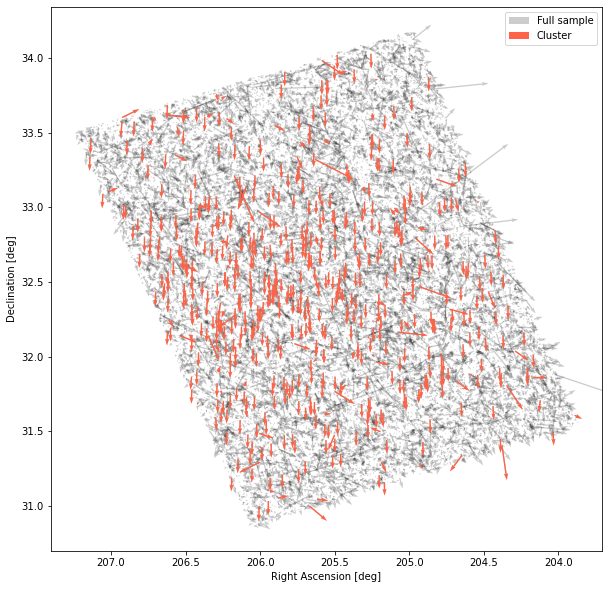

In [212]:
fig, ax = plt.subplots(ncols=1, figsize=(15,10))

ax.quiver(data1_galactic.l.value, data1_galactic.b.value,
          data1_galactic.pm_l_cosb.value, data1_galactic.pm_b.value,
          alpha=0.2, cmap=plt.get_cmap('Greys_r'), scale=1500, label='Full sample');

ax.quiver(cluster1_galactic.l.value, cluster1_galactic.b.value,
          cluster1_galactic.pm_l_cosb.value, cluster1_galactic.pm_b.value,
           alpha=1, color='tomato', scale=1500, label='Cluster');
ax.set_aspect('equal')

# Here we invert the direction of the right ascension axis
ax.invert_xaxis()

ax.set_xlabel('Right Ascension [deg]')
ax.set_ylabel('Declination [deg]');

ax.legend();

## Galactocentric coordinates

In [ ]:
from astropy.coordinates import Galactocentric


In [248]:
cluster1['parallax'].to(u.pc, u.parallax()).mean()

<Quantity 187.25927158 pc>

In [320]:
ra_median = np.median(cluster1['ra'])*cluster1['ra'].unit
dec_median = np.median(cluster1['dec'])*cluster1['dec'].unit
pmra_median = np.median(cluster1['pmra'])*cluster1['pmra'].unit
pmdec_median = np.median(cluster1['pmdec'])*cluster1['pmdec'].unit
radial_velocity_median = np.nanmedian(cluster1['radial_velocity'].compressed())*cluster1['radial_velocity'].unit
distance_median = np.median(cluster1['parallax'].to(u.pc, u.parallax()))

cluster1_galacitc_3d = SkyCoord(ra = ra_median,
                                dec = dec_median,
                                pm_ra_cosdec = pmra_median,
                                pm_dec = pmdec_median,
                                radial_velocity = radial_velocity_median,
                                distance= distance_median,
                                frame='icrs')

In [321]:
cluster1_galactocentric = cluster1_galacitc_3d.transform_to(Galactocentric)
cluster1_galactocentric

<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg): (x, y, z) in pc
    (-8263.82137222, -68.56956773, 121.61212101)
 (v_x, v_y, v_z) in km / s
    (-30.03553086, 224.98472541, -1.97421384)>

In [322]:
print(cluster1_galactocentric.x, cluster1_galactocentric.y, cluster1_galactocentric.z)

-8263.821372216096 pc -68.56956772835062 pc 121.61212100872069 pc


In [323]:
print(cluster1_galactocentric.v_x, cluster1_galactocentric.v_y, cluster1_galactocentric.v_z)

-30.03553085796238 km / s 224.98472540984298 km / s -1.974213838732471 km / s


### ✨ Exercise
- Find the Vizier catalog associated with this publication: [Open cluster kinematics with Gaia DR2⋆ ](https://www.aanda.org/articles/aa/full_html/2018/11/aa34020-18/aa34020-18.html)
- Download the first table of the catalog and call it `soubiran18`.
- Find which item in the catalog is closest to the center of `cluster1`. You can use the average coordinates `cluster1_galacitc_3d` with the `.separation` method to find all the separations to `soubiran18`. Then use `np.argmin` to find the index of the lower separation value.
- What is the NGC name of our cluster?
- Compare our values to the values in the catalog (VR, X, Y, Z, vZ, etc).

In [255]:
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = -1

In [260]:
soubiran18 = Vizier.get_catalogs('J/A+A/619/A155')[0]
soubiran18[0:3]

ID,ID2,RA_ICRS,DE_ICRS,dmode,Nmemb,Nsele,RV,e_RV,s_RV,X,e_X,Y,e_Y,Z,e_Z,U,e_U,V,e_V,W,e_W,Vr,e_Vr,Vphi,e_Vphi,Vz,e_Vz,SimbadName
,,deg,deg,pc,,,km / s,km / s,km / s,pc,pc,pc,pc,pc,pc,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,
str20,str20,float32,float32,float32,int16,int16,float32,float32,float32,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str21
ASCC_10,[KPS2012] MWSC 0275,51.870,34.981,672.0,4,2,-15.67,1.16,1.63,-8923.4,5.1,263.1,2.3,-191.1,1.8,16.27,1.01,-5.24,0.46,-1.67,0.36,-20.08,1.02,247.70,0.43,5.58,0.36,[KPS2012] MWSC 0275
ASCC_101,[KPS2012] MWSC 3070,288.399,36.369,397.3,17,15,-20.17,0.92,3.56,-8194.4,0.5,360.9,1.1,93.9,0.3,-10.08,0.34,-17.12,0.84,-4.60,0.19,9.33,0.31,234.94,0.85,2.65,0.19,[KPS2012] MWSC 3070
ASCC_105,[KPS2012] MWSC 3157,295.548,27.366,551.8,24,20,-13.81,0.50,2.23,-8088.1,0.8,490.6,1.6,33.9,0.1,-4.59,0.23,-12.93,0.45,-5.94,0.06,7.99,0.21,239.26,0.46,1.31,0.06,[KPS2012] MWSC 3157


In [259]:
cluster1_galacocentric = cluster1_galacitc_3d.transform_to(Galactocentric)

In [263]:
soubiran18_coord = SkyCoord(ra=soubiran18['RA_ICRS'],
                            dec=soubiran18['DE_ICRS'],
                            frame='icrs')
print(soubiran18_coord[0:3])

<SkyCoord (ICRS): (ra, dec) in deg
    [( 51.87 , 34.981), (288.399, 36.369), (295.548, 27.366)]>


In [270]:
separations = cluster1_galacitc_3d.separation(soubiran18_coord).deg
separations[0:3]

array([ 69.344246, 120.172264, 130.73988 ], dtype=float32)

In [272]:
idx_min = np.argmin(separations)
idx_min

533

In [273]:
soubiran18[idx_min]

ID,ID2,RA_ICRS,DE_ICRS,dmode,Nmemb,Nsele,RV,e_RV,s_RV,X,e_X,Y,e_Y,Z,e_Z,U,e_U,V,e_V,W,e_W,Vr,e_Vr,Vphi,e_Vphi,Vz,e_Vz,SimbadName
,,deg,deg,pc,,,km / s,km / s,km / s,pc,pc,pc,pc,pc,pc,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,
str20,str20,float32,float32,float32,int16,int16,float32,float32,float32,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str21
NGC_2632,[KPS2012] MWSC 1527,130.054,19.621,185.5,191,186,34.72,0.08,1.10,-8480.8,0.1,-68.5,0.1,113.5,0.1,-42.76,0.07,-20.41,0.04,-9.83,0.06,29.79,0.07,232.08,0.04,-2.58,0.06,[KPS2012] MWSC 1527


In [324]:
cluster1_galacitc_3d

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (130.04755823, 19.7932598, 187.0447171)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-35.89730792, -13.1133851, 34.8609521)>

In [325]:
print(cluster1_galactocentric.v_x, cluster1_galactocentric.v_y, cluster1_galactocentric.v_z)

-30.03553085796238 km / s 224.98472540984298 km / s -1.974213838732471 km / s
